In [18]:
import os
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [19]:
cfg = {
    'train_path': '/kaggle/input/contract-nli-dataset/train.json',
    'test_path': '/kaggle/input/contract-nli-dataset/test.json',
}


In [20]:
def load_data(path: str) -> dict:
    with open(path, 'r') as f:
        return json.load(f)


In [21]:
def get_labels() -> dict:
    return {'NotMentioned': 0, 'Entailment': 1, 'Contradiction': 2}

In [22]:
def clean_text(text: str) -> str:
    text = re.sub(r'[\n\t\r]+', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    return text.strip().lower()

In [23]:
def initialize_majority_ct(data: dict) -> dict:
    majority_ct = {}
    for key, value in data['labels'].items():
        majority_ct[key] = {'NotMentioned': 0, 'Entailment': 0, 'Contradiction': 0}
    return majority_ct

In [24]:
def majority_vote_predict(test_data: dict, majority_ct: dict, labels: dict) -> tuple:
    Y_true, Y_pred = [], []
    for doc in test_data['documents']:
        for key, annotation in doc['annotation_sets'][0]['annotations'].items():
            true_label = annotation['choice']
            Y_true.append(labels[true_label])

            if key in majority_ct:
                majority_ct[key][true_label] += 1
                predicted_label = max(majority_ct[key], key=majority_ct[key].get)
                Y_pred.append(labels[predicted_label])
    return Y_true, Y_pred


In [25]:
def log_metrics(Y_true, Y_pred):
    accuracy = accuracy_score(Y_true, Y_pred)
    report = classification_report(Y_true, Y_pred, output_dict=True)
    cm = confusion_matrix(Y_true, Y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(Y_true, Y_pred))
    
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
        xticklabels=['NotMentioned', 'Entailment', 'Contradiction'],
        yticklabels=['NotMentioned', 'Entailment', 'Contradiction'],
        annot_kws={"size": 14, "weight": "bold", "color": "red"}
    )
    
    plt.xlabel('Predicted Labels', fontsize=14, weight='bold')
    plt.ylabel('True Labels', fontsize=14, weight='bold')
    plt.title('Confusion Matrix', fontsize=16, weight='bold', color='darkgreen')
    plt.tight_layout()
    plt.savefig('majority_vote.png')
    plt.show()

Accuracy: 0.6877092300334768
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.67       903
           1       0.71      0.76      0.73       968
           2       0.70      0.43      0.53       220

    accuracy                           0.69      2091
   macro avg       0.69      0.62      0.64      2091
weighted avg       0.69      0.69      0.68      2091



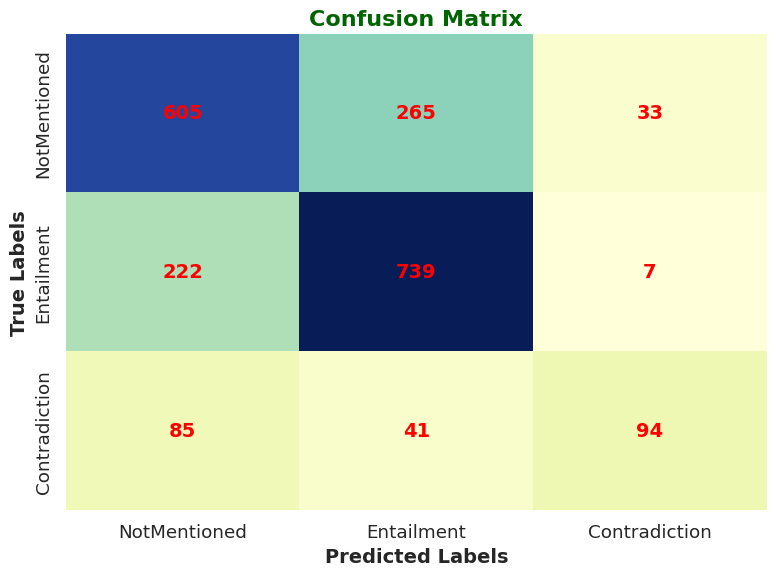

In [26]:
if __name__ == "__main__":

    train_data = load_data(cfg['train_path'])
    test_data = load_data(cfg['test_path'])
    labels = get_labels()
    majority_ct = initialize_majority_ct(train_data)

    Y_true, Y_pred = majority_vote_predict(test_data, majority_ct, labels)
    log_metrics(Y_true, Y_pred)